# Exploratory Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
proj_dir = os.path.split(os.getcwd())[0]

In [2]:
proj_dir


'/mnt/c/Users/Ethan/OneDrive/Documents/School/Data-Analytics-Capstone'

In [3]:
audit_df = pd.read_pickle(f'{proj_dir}/data/cleaned/audit.pkl')
auth_df = pd.read_pickle(f'{proj_dir}/data/cleaned/auth.pkl')
net_df = pd.read_pickle(f'{proj_dir}/data/cleaned/netflow.pkl')
win_df = pd.read_pickle(f'{proj_dir}/data/cleaned/win-security.pkl')

## Host Logs

### `audit` Logs

With these audit logs, I want to review the following:
- Distribution of unique values for the categorical features.

I also have the following concerns:
- Lots of columns are mostly null values.
- Lots of rows have a null value
- Apply some sort of feature reduction, otherwise a classifier will take ages to get through it.

After we play around, I'll talk about what's next for this DataFrame.

In [5]:
audit_df.head()

,type,ts,tsid,auid,pid,uid,ses,msg,subj,AUID,UID,Activity,Stage,DefenderResponse,Signature
0,DAEMON_START,2021-05-24 06:29:27.969,9329,4294967295,13687,0,4294967295,NaN,unconfined,NaN,NaN,Normal,Benign,Benign,Normal
1,CONFIG_CHANGE,2021-05-24 06:29:27.983,489,4294967295,0,NaN,4294967295,NaN,NaN,NaN,NaN,Normal,Benign,Benign,Normal
2,CONFIG_CHANGE,2021-05-24 06:29:27.983,490,4294967295,0,NaN,4294967295,NaN,NaN,NaN,NaN,Normal,Benign,Benign,Normal
3,CONFIG_CHANGE,2021-05-24 06:29:27.983,491,4294967295,0,NaN,4294967295,NaN,NaN,NaN,NaN,Normal,Benign,Benign,Normal
4,SERVICE_START,2021-05-24 06:29:27.987,492,4294967295,1,0,4294967295,"'unit=auditd comm=""systemd"" exe=""/lib/systemd/...",NaN,NaN,NaN,Normal,Benign,Benign,Normal


In [93]:
audit_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264320 entries, 0 to 264319
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   type              264320 non-null  category      
 1   ts                264320 non-null  datetime64[ns]
 2   tsid              264320 non-null  uint32        
 3   auid              258041 non-null  category      
 4   pid               264320 non-null  uint32        
 5   uid               258020 non-null  category      
 6   ses               264320 non-null  uint32        
 7   msg               223500 non-null  object        
 8   subj              226225 non-null  category      
 9   AUID              226222 non-null  category      
 10  UID               226210 non-null  category      
 11  Activity          264320 non-null  category      
 12  Stage             264320 non-null  category      
 13  DefenderResponse  264320 non-null  category      
 14  Sign

In [96]:
nunique_sorted = audit_df.nunique().sort_values(ascending=True)
nunique_sorted

Stage                    1
DefenderResponse         1
Signature                1
Activity                 1
uid                      2
subj                     2
UID                      2
auid                     4
AUID                     4
type                    20
msg                   2600
ses                  11838
pid                  38401
tsid                 78497
ts                  124815
dtype: int64

In [ ]:
cols = nunique_sorted[:-5].index
len(cols)

10

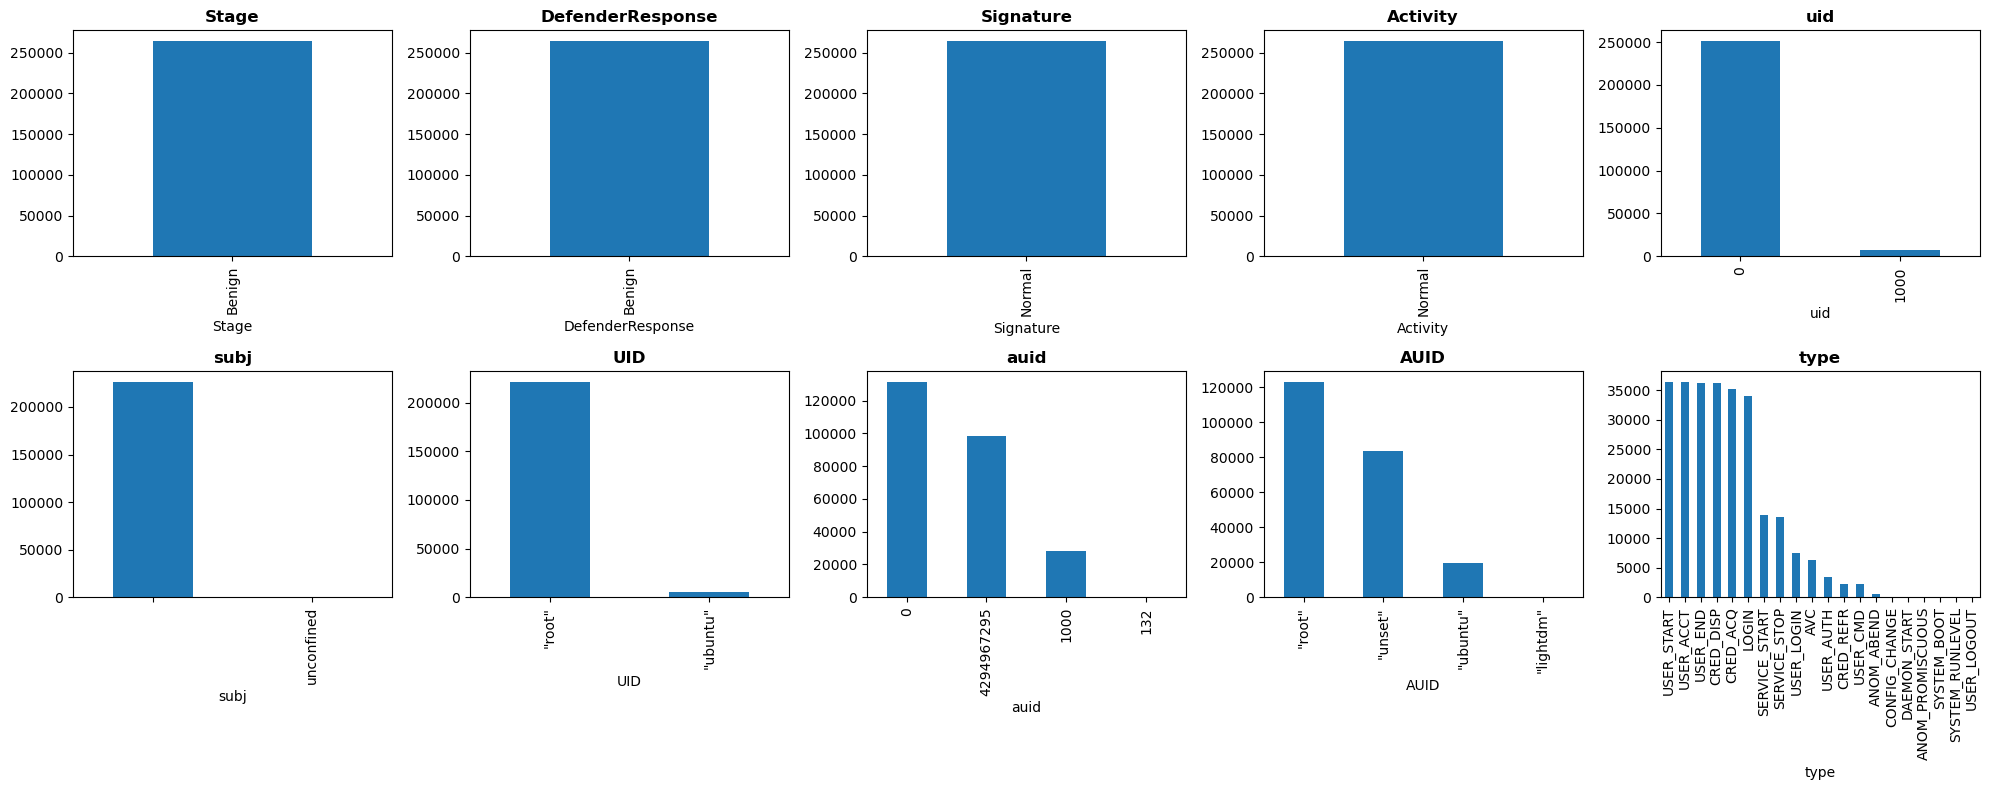

In [99]:
fig, axes = plt.subplots(2, 5, figsize=(20,8))
axes = axes.flatten()

for i, col in enumerate(cols):
    audit_df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col, fontweight='bold')

plt.tight_layout()
plt.show()

Alright, so the plan is:
- Select the best performing classification model.
- Fit a classification model built on a majority of the features, then apply feature reduction techniques.
- Pit the old model against the new to validate performance.

### `auth` Logs

I'm interested in the following:
- What are some common features among benign logs?
  - Successes and failures
- What about for the logs of malicious activity?


In [4]:
auth_df.head()

,ts,hostname,app,pid,msg,Activity,Stage,DefenderResponse,Signature
0,2021-06-13 00:05:01,kali,CRON,328914,pam_unix(cron:session): session opened for use...,Normal,Benign,Benign,NaN
1,2021-06-13 00:05:01,kali,CRON,328914,pam_unix(cron:session): session closed for use...,Normal,Benign,Benign,NaN
2,2021-06-13 00:09:01,kali,CRON,328918,pam_unix(cron:session): session opened for use...,Normal,Benign,Benign,NaN
3,2021-06-13 00:09:01,kali,CRON,328918,pam_unix(cron:session): session closed for use...,Normal,Benign,Benign,NaN
4,2021-06-13 00:15:01,kali,CRON,328966,pam_unix(cron:session): session opened for use...,Normal,Benign,Benign,NaN


In [61]:
auth_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89209 entries, 0 to 89208
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ts                89209 non-null  datetime64[ns]
 1   hostname          89209 non-null  category      
 2   app               89209 non-null  category      
 3   pid               89209 non-null  uint32        
 4   msg               89209 non-null  object        
 5   Activity          89209 non-null  category      
 6   Stage             89209 non-null  category      
 7   DefenderResponse  89209 non-null  category      
 8   Signature         74 non-null     category      
dtypes: category(6), datetime64[ns](1), object(1), uint32(1)
memory usage: 11.2 MB


### Windows `Security.evtx` Logs

Here are some things I am curious about:
- Frequency of given event IDs over the duration of the capture

In [5]:
win_df.head()

,Type,DateTime,Source,EventID,TaskCategory,Description,Activity,Stage,DefenderResponse,Signature,LogMessage
0,Audit Success,7/17/2021 10:28:37 PM,Microsoft-Windows-Security-Auditing,4672,Special Logon,Special privileges assigned to new logon.,Normal,Benign,Benign,NaN,Subject:\n\tSecurity ID:\t\tSYSTEM\n\tAccount ...
1,Audit Success,7/17/2021 10:28:37 PM,Microsoft-Windows-Security-Auditing,4624,Logon,An account was successfully logged on.,Normal,Benign,Benign,NaN,Subject:\n\tSecurity ID:\t\tSYSTEM\n\tAccount ...
2,Audit Success,7/17/2021 10:28:36 PM,Microsoft-Windows-Security-Auditing,4798,User Account Management,A users local group membership was enumerated.,Normal,Benign,Benign,NaN,Subject:\n\tSecurity ID:\t\tDESKTOP-56DUI1B\us...
3,Audit Success,7/17/2021 10:28:36 PM,Microsoft-Windows-Security-Auditing,4799,Security Group Management,A security-enabled local group membership was ...,Normal,Benign,Benign,NaN,Subject:\n\tSecurity ID:\t\tSYSTEM\n\tAccount ...
4,Audit Success,7/17/2021 10:28:36 PM,Microsoft-Windows-Security-Auditing,4799,Security Group Management,A security-enabled local group membership was ...,Normal,Benign,Benign,NaN,Subject:\n\tSecurity ID:\t\tSYSTEM\n\tAccount ...


In [57]:
win_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143473 entries, 0 to 143472
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Type              143473 non-null  category
 1   DateTime          143473 non-null  object  
 2   Source            143473 non-null  category
 3   EventID           143473 non-null  category
 4   TaskCategory      143473 non-null  category
 5   Description       143473 non-null  category
 6   Activity          143473 non-null  category
 7   Stage             143473 non-null  category
 8   DefenderResponse  143473 non-null  category
 9   Signature         360 non-null     category
 10  LogMessage        143412 non-null  object  
dtypes: category(9), object(2)
memory usage: 155.5 MB


In [56]:
categories = win_df.columns[win_df.nunique() < 100]
win_df[categories] = win_df[categories].astype('category')

In [100]:
nunique_sorted = win_df.nunique().sort_values(ascending=True)
nunique_sorted

DefenderResponse        1
Type                    2
Activity                2
Source                  2
Signature               2
Stage                   2
TaskCategory           14
Description            29
EventID                30
LogMessage          25279
DateTime            32796
dtype: int64

In [104]:
cols = ['DefenderResponse', 'Type', 'Activity', 'Source', 'Signature', 'Stage', 'TaskCategory', 'EventID']
len(cols)

8

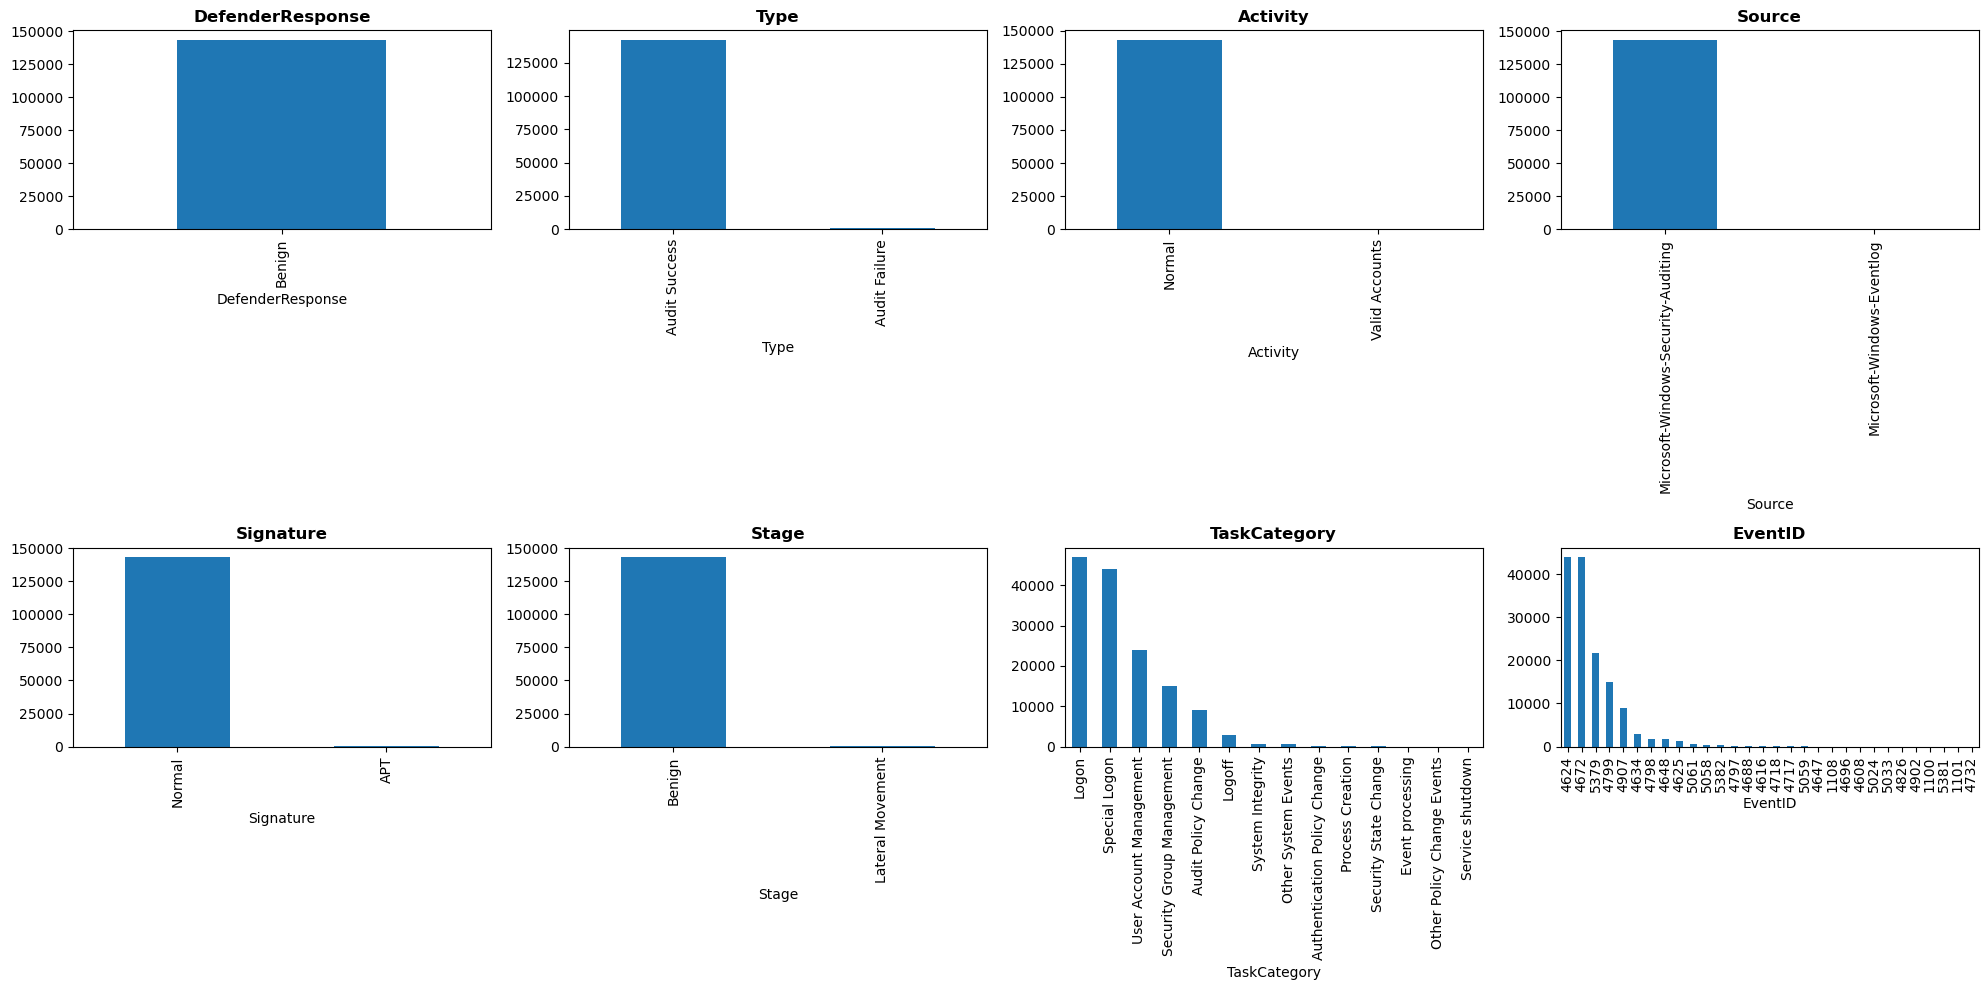

In [110]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()

for i, col in enumerate(cols):
    win_df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col, fontweight='bold')

plt.tight_layout()
plt.show()

## Network Logs

### Netflow

#### All Traffic

In [4]:
net_df.head()

,flow_start,flow_end,expiration_id,src_ip,src_mac,src_port,dst_ip,dst_mac,dst_port,protocol,...,dst2src_rst_packets,dst2src_fin_packets,application_name,application_category_name,server_fingerprint,user_agent,Activity,Stage,DefenderResponse,Signature
0,2021-05-26 18:02:55.872,2021-05-26 18:07:18.016,0.0,10.1.2.17,fa:16:3e:a2:d6:e6,123.0,192.81.135.252,fa:16:3e:10:2d:11,123.0,17.0,...,0.0,0.0,NTP,System,NaN,NaN,Normal,Benign,Benign,Normal
1,2021-05-26 18:02:55.872,2021-05-26 18:07:18.016,0.0,10.1.2.17,fa:16:3e:a2:d6:e6,123.0,74.6.168.72,fa:16:3e:10:2d:11,123.0,17.0,...,0.0,0.0,NTP,System,NaN,NaN,Normal,Benign,Benign,Normal
2,2021-05-26 18:05:06.944,2021-05-26 18:05:06.944,0.0,10.1.2.17,fa:16:3e:a2:d6:e6,123.0,23.131.160.7,fa:16:3e:10:2d:11,123.0,17.0,...,0.0,0.0,NTP,System,NaN,NaN,Normal,Benign,Benign,Normal
3,2021-05-26 18:02:55.872,2021-05-26 18:02:55.872,0.0,10.1.2.17,fa:16:3e:a2:d6:e6,123.0,209.115.181.108,fa:16:3e:10:2d:11,123.0,17.0,...,0.0,0.0,NTP,System,NaN,NaN,Normal,Benign,Benign,Normal
4,2021-05-26 18:05:06.944,2021-05-26 18:05:06.944,0.0,10.1.2.17,fa:16:3e:a2:d6:e6,123.0,108.61.73.243,fa:16:3e:10:2d:11,123.0,17.0,...,0.0,0.0,NTP,System,NaN,NaN,Normal,Benign,Benign,Normal


In [56]:
net_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6877157 entries, 0 to 6877156
Data columns (total 63 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   flow_start                   datetime64[ns]
 1   flow_end                     datetime64[ns]
 2   expiration_id                uint16        
 3   src_ip                       category      
 4   src_mac                      category      
 5   src_port                     uint16        
 6   dst_ip                       category      
 7   dst_mac                      category      
 8   dst_port                     uint16        
 9   protocol                     uint16        
 10  bidirectional_first_seen_ms  uint32        
 11  bidirectional_last_seen_ms   uint32        
 12  bidirectional_duration_ms    uint32        
 13  bidirectional_packets        uint32        
 14  bidirectional_bytes          uint32        
 15  src2dst_first_seen_ms        uint32        
 16  

In [137]:
plotme = [
    ('src_ip', net_df.src_ip.value_counts().sort_values(ascending=False).head(5)),
    ('src_mac', net_df.src_mac.value_counts().sort_values(ascending=False).head(5)),
    ('src_port', net_df.src_port.value_counts().sort_values(ascending=False).head(5)),
    ('dst_port', net_df.dst_port.value_counts().sort_values(ascending=False).head(5)),
    ('dst_ip', net_df.dst_ip.value_counts().sort_values(ascending=False).head(5)),
    ('dst_mac', net_df.dst_mac.value_counts().sort_values(ascending=False).head(5)),
    ('application_name', net_df.application_name.value_counts().sort_values(ascending=False).head(5)),
    ('application_category_name', net_df.application_category_name.value_counts().sort_values(ascending=False).head(5)),
    ('server_fingerprint', net_df.server_fingerprint.value_counts().sort_values(ascending=False).head(5)),
    ('user_agent', net_df.user_agent.value_counts().sort_values(ascending=False).head(5)),
    ('Activity', net_df.Activity.value_counts().sort_values(ascending=False).head(5)),
    ('Stage', net_df.Stage.value_counts().sort_values(ascending=False).head(5)),
    ('DefenderResponse', net_df.DefenderResponse.value_counts().sort_values(ascending=False).head(5)),
    ('Signature', net_df.Signature.value_counts().sort_values(ascending=False).head(5))
]

In [139]:
len(plotme)

14

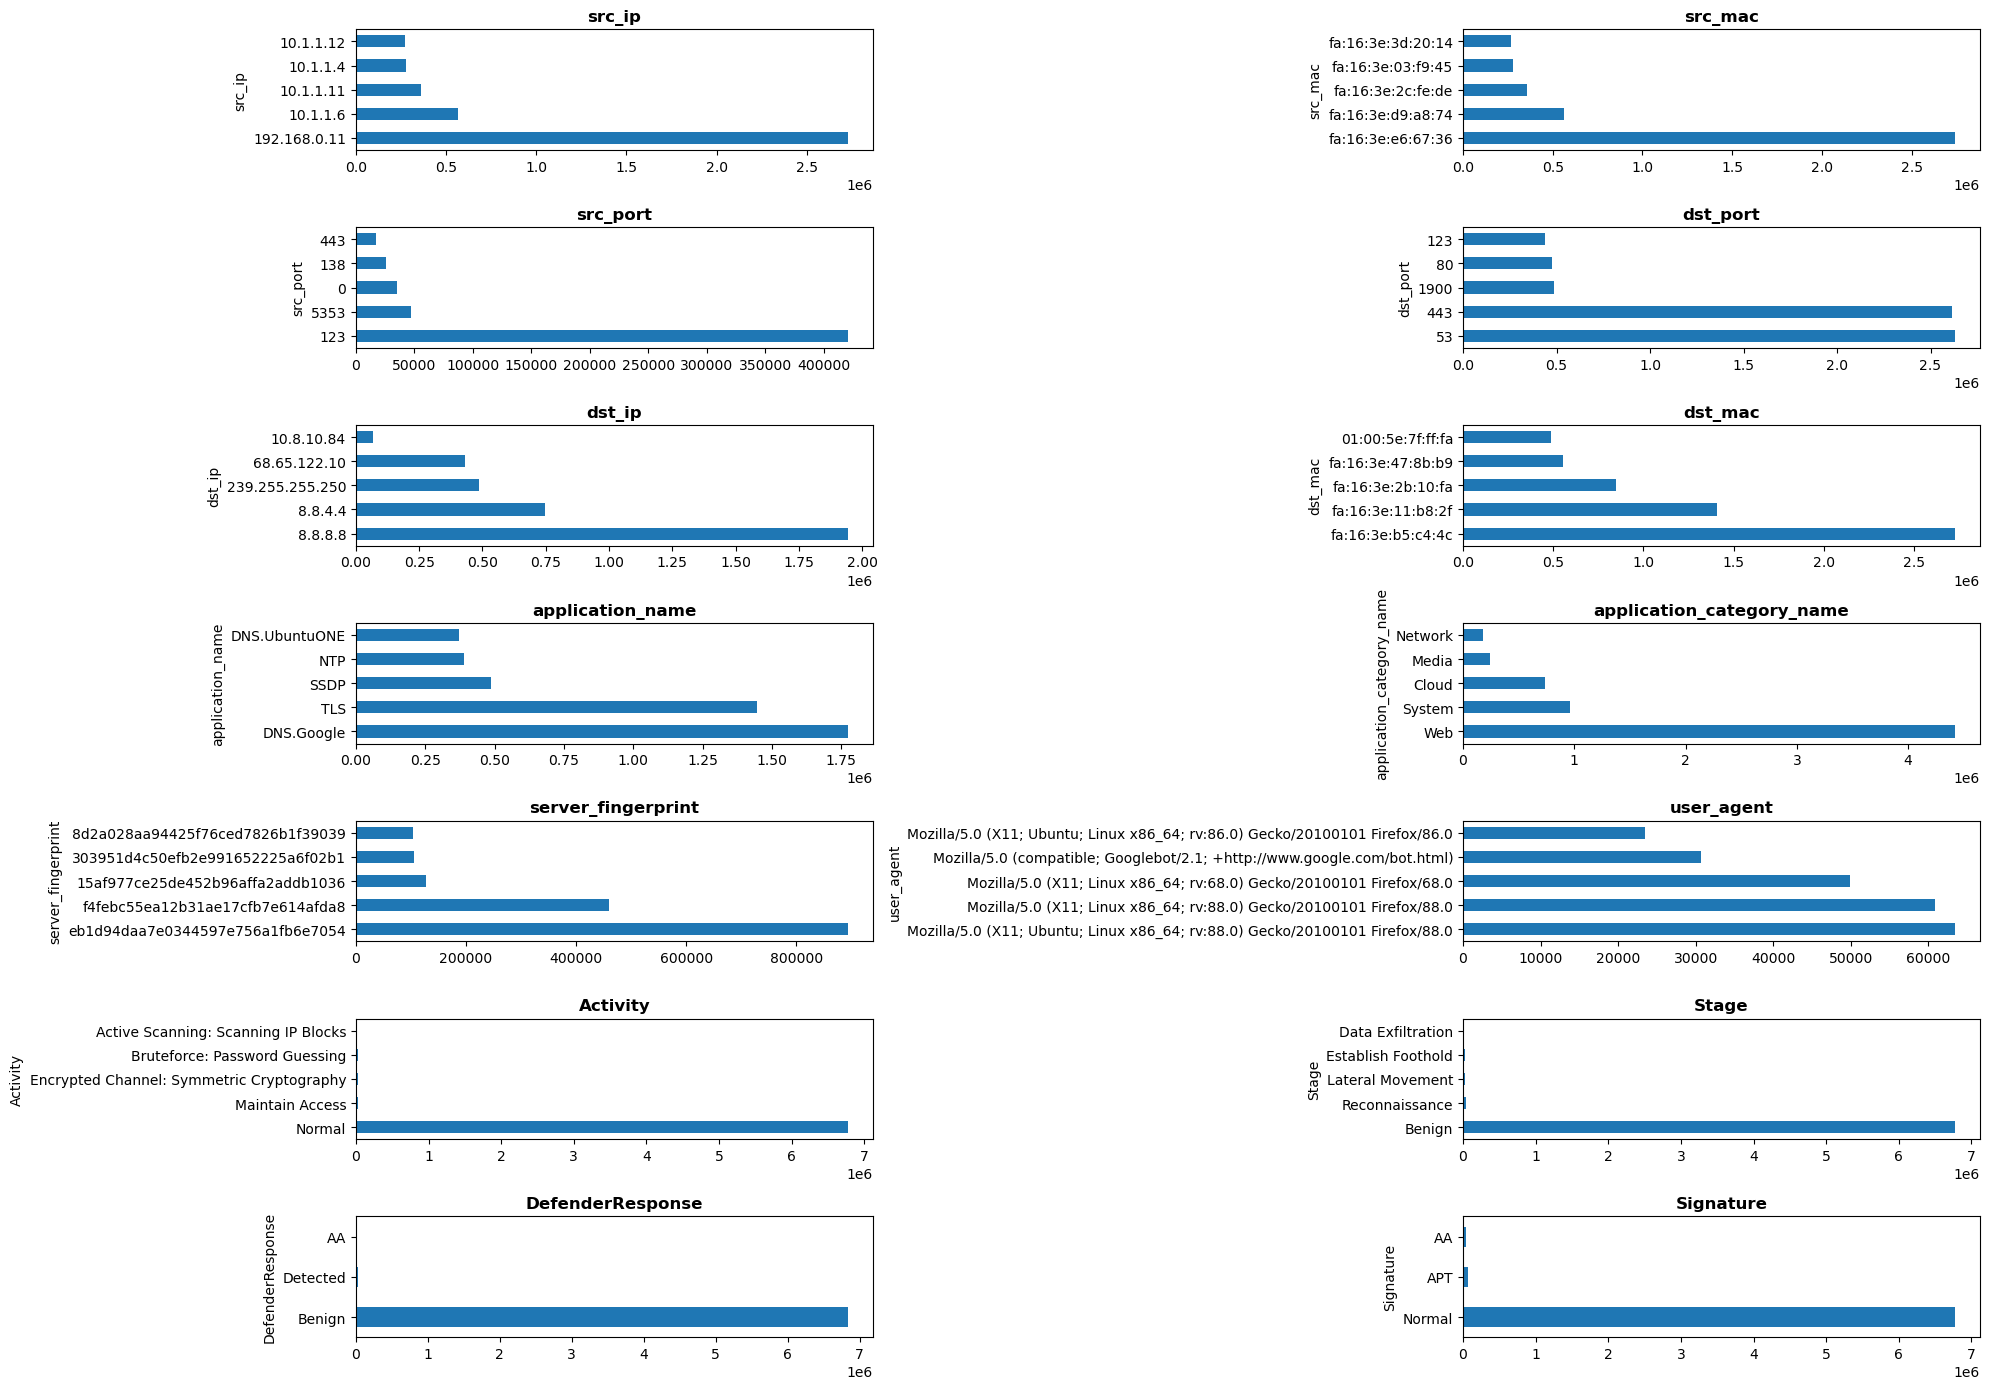

In [140]:
fig, axes = plt.subplots(7, 2, figsize=(20,14))
axes = axes.flatten()

for i, (title, data) in enumerate(plotme):
    data.plot(kind='barh', ax=axes[i])
    axes[i].set_title(title, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
nunique_sorted = net_df.nunique().sort_values(ascending=True)


In [95]:
cols = net_df[nunique_sorted[(nunique_sorted < 25)].index].columns
print(len(cols))

df = net_df[cols].sample(10)

20


/tmp/ipykernel_17585/4061442416.py:8: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


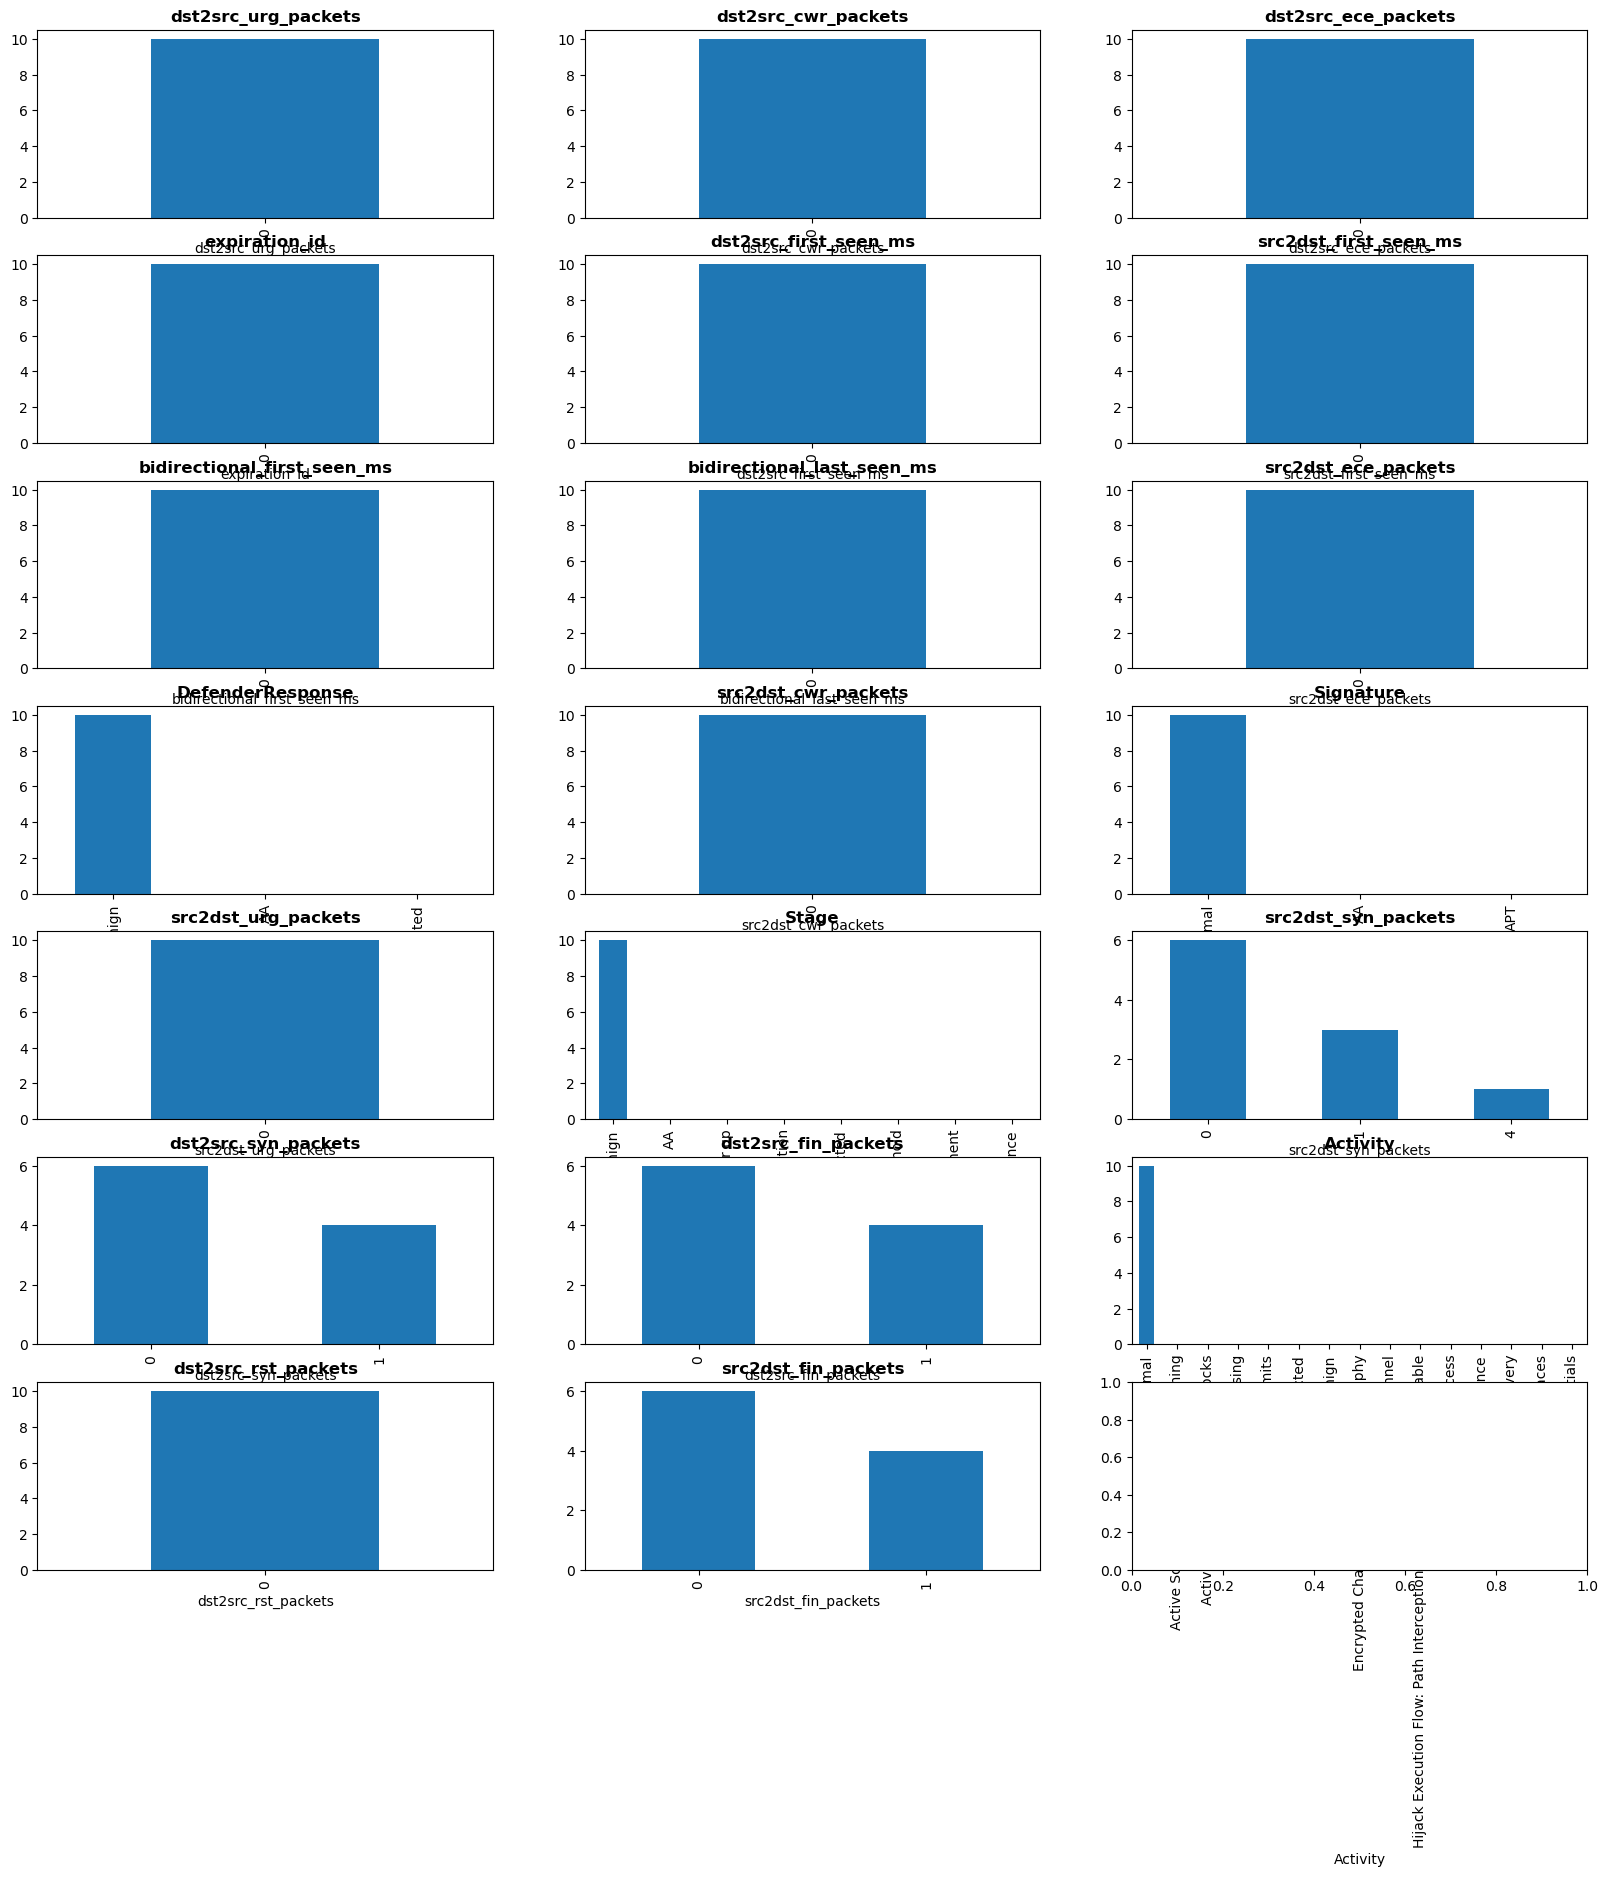

In [ ]:
fig, axes = plt.subplots(7, 3, figsize=(20,20))
axes = axes.flatten()

for i, col in enumerate(cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col, fontweight='bold')

plt.tight_layout()
plt.show()

#### Malicious Traffic

In [151]:
bad_df = net_df.query('Activity != "Normal"')

In [152]:
plotme = [
    ('src_ip', bad_df.src_ip.value_counts().sort_values(ascending=False).head(5)),
    ('src_mac', bad_df.src_mac.value_counts().sort_values(ascending=False).head(5)),
    ('src_port', bad_df.src_port.value_counts().sort_values(ascending=False).head(5)),
    ('dst_port', bad_df.dst_port.value_counts().sort_values(ascending=False).head(5)),
    ('dst_ip', bad_df.dst_ip.value_counts().sort_values(ascending=False).head(5)),
    ('dst_mac', bad_df.dst_mac.value_counts().sort_values(ascending=False).head(5)),
    ('application_name', bad_df.application_name.value_counts().sort_values(ascending=False).head(5)),
    ('application_category_name', bad_df.application_category_name.value_counts().sort_values(ascending=False).head(5)),
    ('server_fingerprint', bad_df.server_fingerprint.value_counts().sort_values(ascending=False).head(5)),
    ('user_agent', bad_df.user_agent.value_counts().sort_values(ascending=False).head(5)),
    ('Activity', bad_df.Activity.value_counts().sort_values(ascending=False).head(5)),
    ('Stage', bad_df.Stage.value_counts().sort_values(ascending=False).head(5)),
    ('DefenderResponse', bad_df.DefenderResponse.value_counts().sort_values(ascending=False).head(5)),
    ('Signature', bad_df.Signature.value_counts().sort_values(ascending=False).head(5))
]

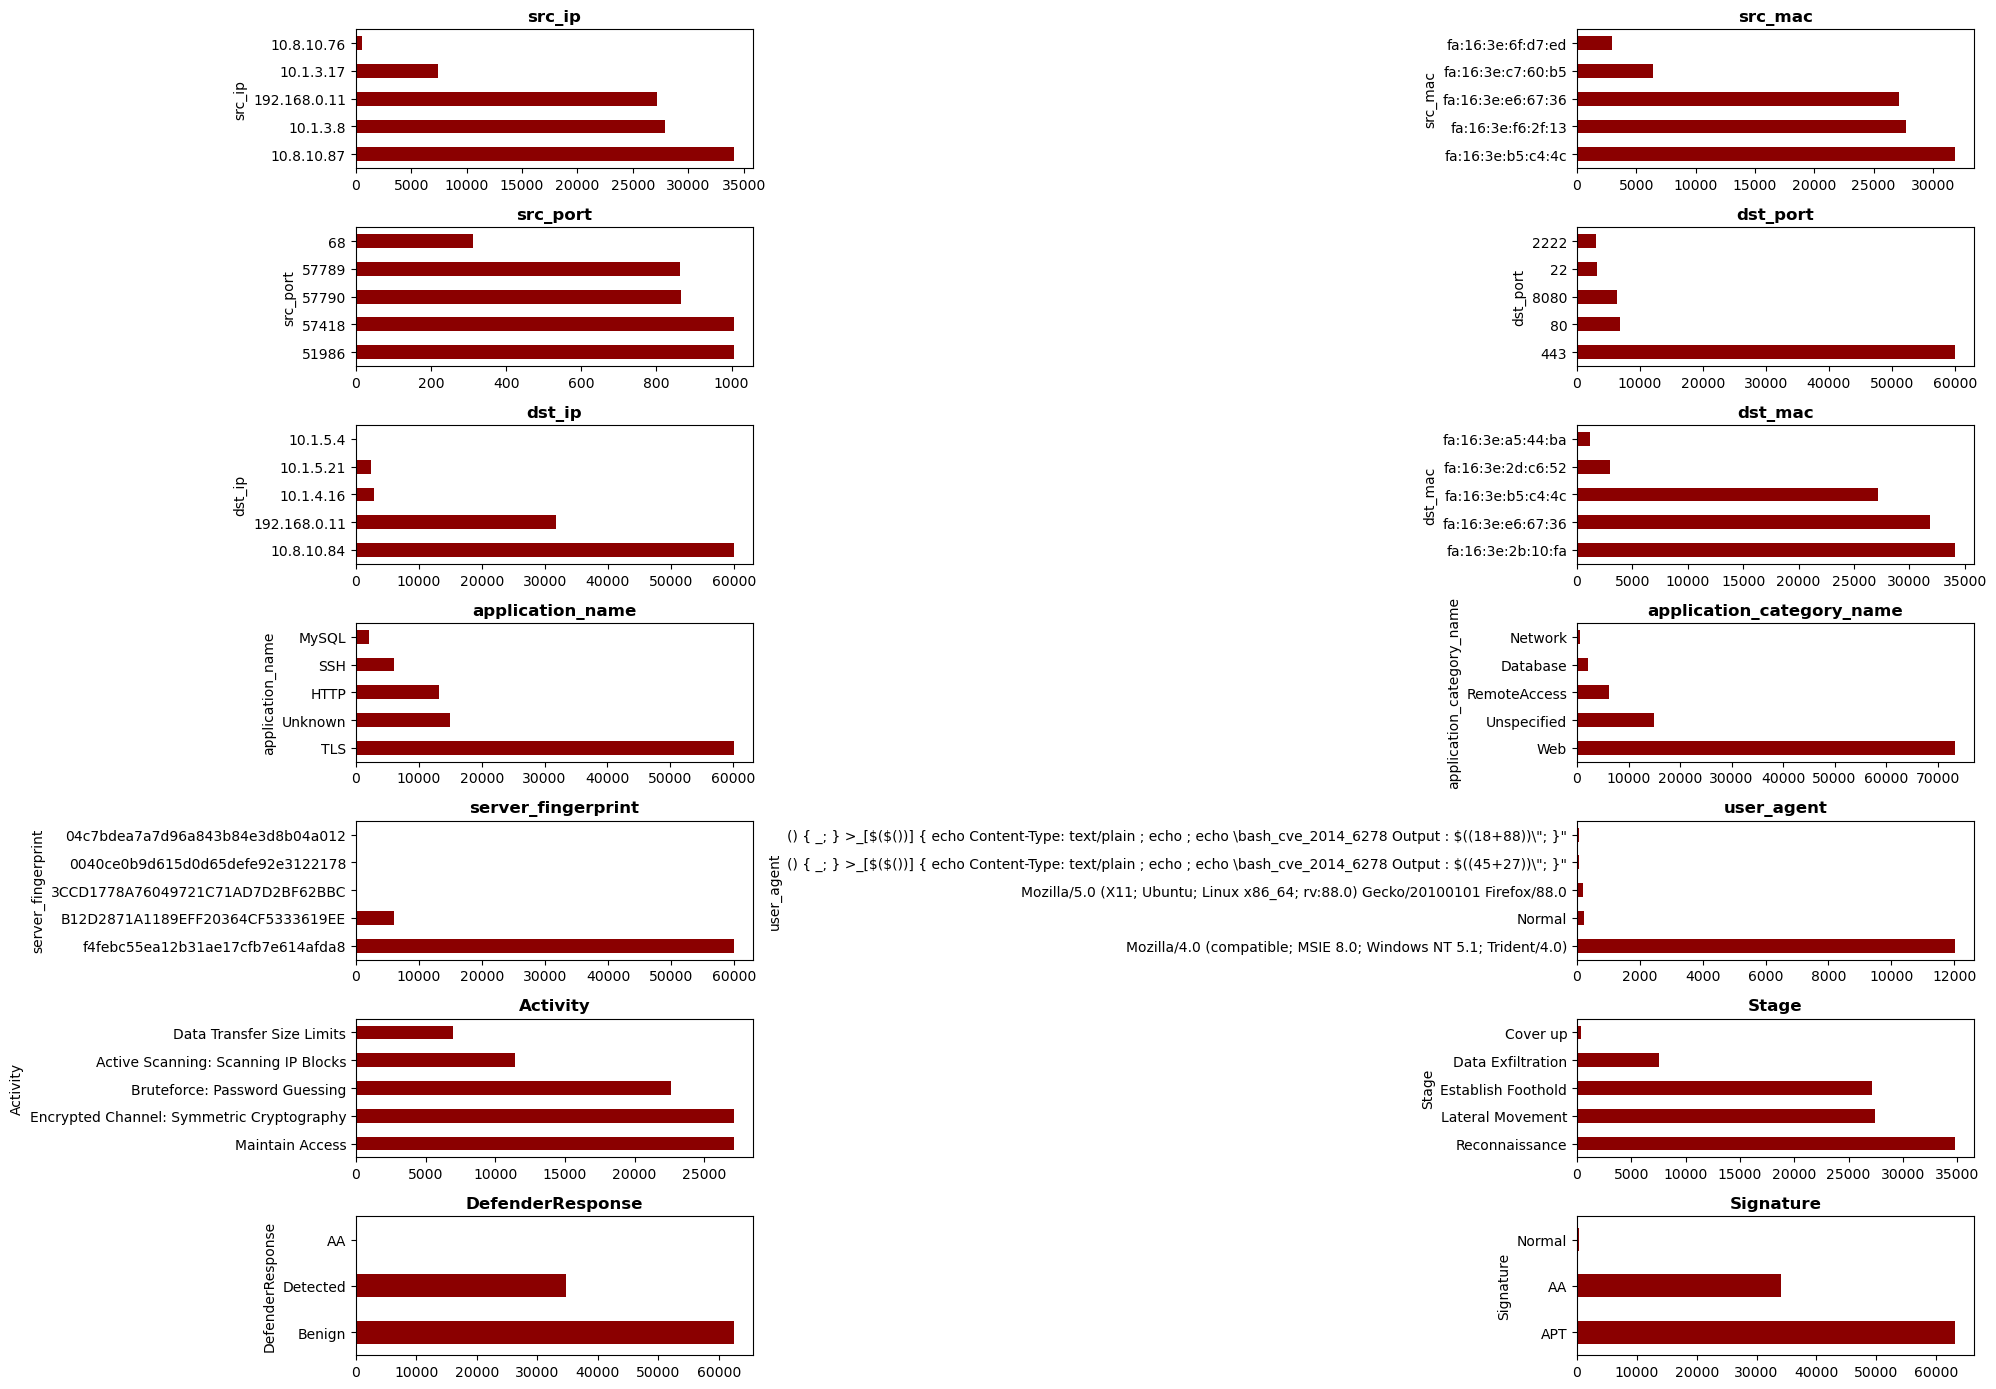

In [156]:
fig, axes = plt.subplots(7, 2, figsize=(20,14))
axes = axes.flatten()

for i, (title, data) in enumerate(plotme):
    data.plot(kind='barh', ax=axes[i], color='darkred')
    axes[i].set_title(title, fontweight='bold')

plt.tight_layout()
plt.show()